In [367]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
#from scipy.special import hyp2f1, factorial, gamma
from mpmath import hyp2f1, factorial, gamma
fsc = constants.alpha
Ry_in_J = constants.value('Rydberg constant times hc in J')
Hz_in_eV = constants.h/constants.e
aB_in_cm = constants.value('Bohr radius') * 1.e2

def gaunt_free_free(Z, beta, E):
    """calculate the Gaunt factor for free-free radiation
    
    Arguments:
    Z : atomic number, int
    beta : velocity of incident electrons in units of c, float or array
    E : energy of photon in units of Ha, float or array"""
    
    eta_i = Z * fsc / beta
    k_i = beta / fsc
    eta_f = Z * fsc / (beta**2 + 2*E*fsc**2)**.5
    k_f = Z / eta_f
    
    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)
    
    out = 2*3**.5/np.pi/eta_i/eta_f * I0 * \
            ((eta_i**2 + eta_f**2 + 2*eta_i**2*eta_f**2)*I0 -\
             2 * eta_i * eta_f * (1 + eta_i**2)**.5*(1+eta_f**2)**.5*I1)
    return out.real

def I(eta_i, eta_f, k_i, k_f, l):
    """radial hypergeometric function"""

    Il =  1/4*(4.* k_i * k_f / (k_i - k_f)**2)**(l+1) * \
            np.exp(np.pi/2*abs(eta_i - eta_f)) * abs(gamma(l+1+1j*eta_i) * gamma(l+1+1j*eta_f) ) / \
            gamma(2.*l + 2) * G(eta_i, eta_f, k_i, k_f, l)
    return Il

def G(eta_i, eta_f, k_i, k_f, l):
    """radial hypergeometric function"""
    Gl = abs((k_f - k_i) / (k_f + k_i))**(1j*eta_i + 1j*eta_f) *\
        hyp2f1(l+1-1j*eta_f, l+1-1j*eta_i, 2.*l+2, -4.*k_i*k_f/(k_i-k_f)**2)

    return Gl

def free_free_emission_spectrum(Z, en, E):
    if en >= E:
        return 0.
    g_ff = gaunt_free_free(Z, fsc * (2*(E - en))**.5, en)
    return 64 * np.pi**2 / 3 / 3**.5 * Z**2 * fsc**3 / (2*E)**.5 * g_ff

def free_free_thermal_spectrum(Z, T, E):
    distribution = lambda x: x**.5 * np.exp(-x / T)
    norm = scipy.integrate.quad(distribution, 0, np.inf)[0]
    spectrum = np.zeros_like(E)
    for i, en in enumerate(E):
        def integrand(kin):
            return distribution(kin)*free_free_emission_spectrum(Z, en, kin)
        avg = scipy.integrate.quad(integrand, en, np.inf)[0]
        spectrum[i] = avg/norm
    return spectrum

In [258]:
Z = 1.0
energies = np.logspace(-5,8,101) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 15) # Ry

gff1 = [[gaunt_free_free(Z, v, photon_energy/2.) for v in velocities] for photon_energy in photon_energies]


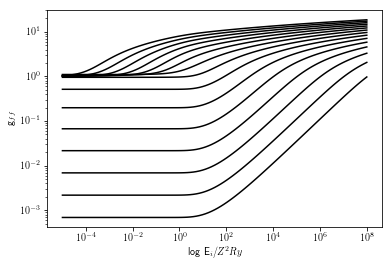

In [260]:
[plt.loglog(energies, gff1[i],'k') for i in range(len(photon_energies))]
plt.xlabel(r'log E_i/Z^2 Ry')
plt.ylabel(r'g_{ff}')

In [262]:
Z = 1.0
energies = np.logspace(-5,8,14) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 101) # Ry

gff2 = [[gaunt_free_free(Z, v, photon_energy/2.) for photon_energy in photon_energies] for v in velocities]

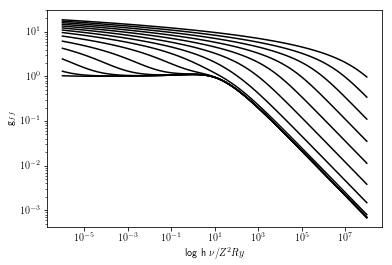

In [264]:
[plt.loglog(photon_energies, gff2[i],'k') for i in range(len(velocities))]
plt.xlabel(r'log h \nu / Z^2 Ry')
plt.ylabel(r'g_{ff}')

In [270]:
l_nm = np.logspace(-4,2,100)

# Determine energy range.
energies_eV = 1239.8/l_nm
energies_Ha = energies_eV/27.2

Ha_to_eV = 27.2
T = np.logspace(1,5,5)
spectra_eV = [free_free_thermal_spectrum(1.0, t/Ha_to_eV, energies_Ha) for t in T]

### Convert to wavelength spectrum.
spectra_nm = [spectrum_eV / l_nm**2 for spectrum_eV in spectra_eV]
outdata = spectra_nm


/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


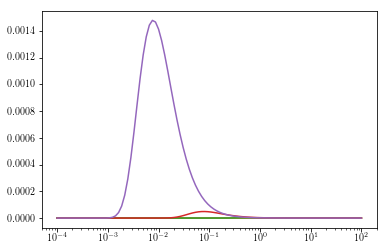

In [393]:
[plt.semilogx(l_nm,spectra_nm[i] ) for i in range(len(spectra_nm))];

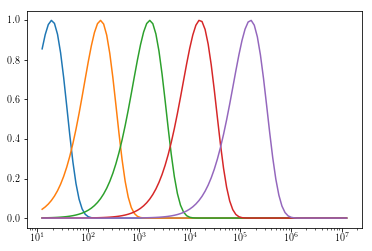

In [280]:
[plt.semilogx(energies_eV,spectra_nm[i]/spectra_nm[i].max() ) for i in range(len(spectra_nm))];

In [216]:
import numpy as np
l_nm1 = np.logspace(-4,2,100)

# Determine energy range.
energies_eV1 = 1239.8/l_nm1
energies_Ha1 = energies_eV1/27.2

Ha_to_eV1 = 27.2
T1 = [4e5]#np.linspace(10,50,41)
spectra_eV1 = [free_free_thermal_spectrum(1.0, t/Ha_to_eV1, energies_Ha1) for t in T1]

### Convert to wavelength spectrum.
spectra_nm1 = [spectrum_eV / l_nm1**2 for spectrum_eV in spectra_eV1]
outdata1 = spectra_nm1


/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


[[<matplotlib.lines.Line2D at 0x122f0ac18>]]

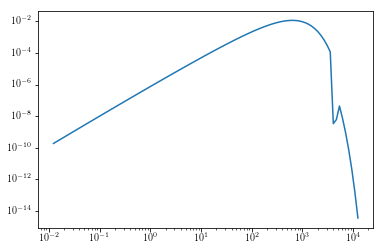

In [218]:
[plt.loglog(energies_eV1/1000,spectra_nm1[i]) for i in range(len(spectra_nm1))]

In [215]:
free_free_thermal_spectrum(1,14700,energies_Ha1[-5:])

array([  1.82221221e-06,   1.84612930e-06,   1.87004613e-06,
         1.89396278e-06,   1.91787928e-06])

In [205]:
4e5/Ha_to_eV1

14705.882352941177

In [292]:
hyp2f1(1+1j, 0.75, 10j, 1+5j)

mpc(real='0.88348333197134798', imag='0.70538868806481048')

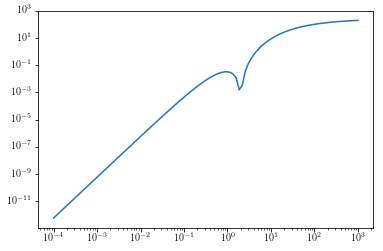

In [368]:

energies = 10.**numpy.linspace(-4, 3, 101)
gbf = []
n = 1
l = 0
for en in energies:
    g = abs(gaunt_bound_free(1.0, n, l, en))

    gbf.append(g)

plt.loglog(energies, gbf)
plt.show()

In [390]:
Z = 1.0
energies = np.logspace(-4,4,101) # Ry

gbf1 = [[abs(gaunt_bound_free(Z, i, 0, energy)) for energy in energies] for i in range(1,7)]


In [391]:
np.max(gbf1)

mpf('8418.9427620445804')

[[<matplotlib.lines.Line2D at 0x1271f05f8>],

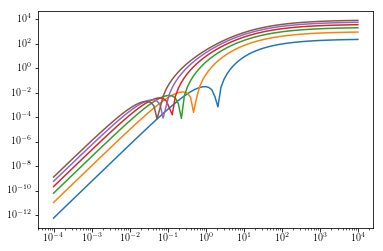

In [392]:
[plt.loglog(energies, gbf1[i]) for i in range(6)]

In [324]:
es = [.1e13, ]

mpc(real='-1.1914105827290977e-8', imag='255.47699275863243')

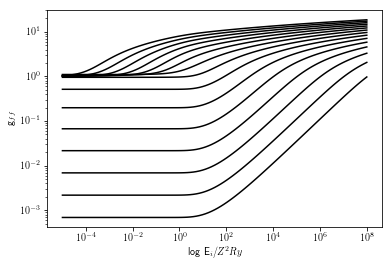

In [260]:
[plt.loglog(energies, gff1[i],'k') for i in range(len(photon_energies))]
plt.xlabel(r'log E_i/Z^2 Ry')
plt.ylabel(r'g_{ff}')

In [262]:
Z = 1.0
energies = np.logspace(-5,8,14) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 101) # Ry

gff2 = [[gaunt_free_free(Z, v, photon_energy/2.) for photon_energy in photon_energies] for v in velocities]

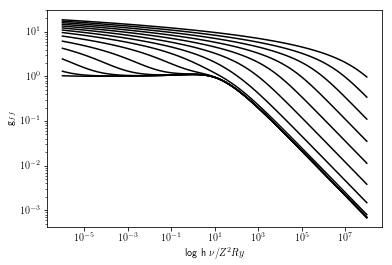

In [264]:
[plt.loglog(photon_energies, gff2[i],'k') for i in range(len(velocities))]
plt.xlabel(r'log h \nu / Z^2 Ry')
plt.ylabel(r'g_{ff}')